In [1]:
# use 5-4 matching to show the approximation of 3.8 - 3.9 - 3.10

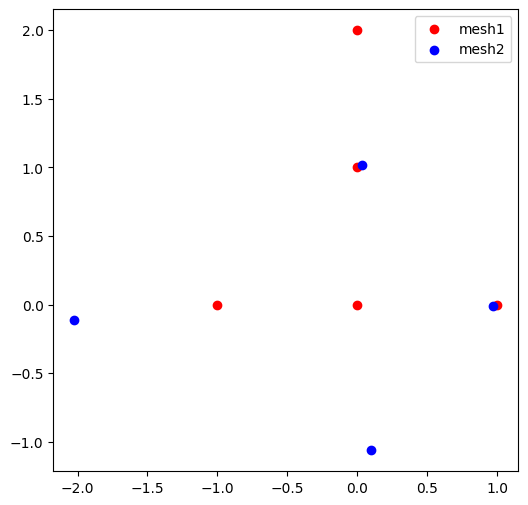

Minimum Vertex Cover: ((1, 1), (1, 2), (1, 3), (1, 4), (2, 1), (2, 2), (2, 3), (2, 4), (3, 1), (3, 3), (3, 4), (4, 2), (4, 3), (4, 4), (5, 1), (5, 2), (5, 3))
Size of MVC: 17


In [2]:
import itertools
import networkx as nx
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
# Function to check if a set of vertices is a vertex cover
def is_vertex_cover(graph, vertices):
    covered_edges = set()
    for vertex in vertices:
        for neighbor in graph[vertex]:
            covered_edges.add(frozenset([vertex, neighbor]))
    return len(covered_edges) == graph.number_of_edges()

# Function to find the minimum vertex cover using brute-force
def minimum_vertex_cover(graph):
    vertices = list(graph.nodes)
    n = len(vertices)
    for r in range(1, n+1):
        for subset in itertools.combinations(vertices, r):
            if is_vertex_cover(graph, subset):
                return subset
    return None

# Parameters
threshold = 0.2  # Adjust threshold as needed

# Create a mesh of points
mesh1 = np.array([[0, 0], [0, 2], [1, 0], [-1, 0], [0, 1]])
mesh2 = np.array([[0, -1, 0], [0, 1, 0], [-2, 0, 0], [1, 0, 0]])
mesh2 = mesh2 + 3e-1 * (np.random.rand(*mesh2.shape) - 0.5)

plt.figure(figsize=(6, 6))
plt.scatter(mesh1[:, 0], mesh1[:, 1], color='red', label='mesh1')
plt.scatter(mesh2[:, 0], mesh2[:, 1], color='blue', label='mesh2')
plt.legend()
plt.show()

C1 = cdist(mesh1, mesh1)
C2 = cdist(mesh2, mesh2)
n = C1.shape[0]
m = C2.shape[0]

# Build graph
G = nx.Graph()
for i in range(n):
    for j in range(m):
        vertex = (i + 1, j + 1)
        G.add_node(vertex)

tensor4 = np.zeros((n, m, n, m))
C1_exp = C1[:, None, :, None]
C2_exp = C2[None, :, None, :]
tensor4 = (C1_exp - C2_exp) ** 2

positions = np.where(tensor4 > threshold ** 2)
vertex_positions = positions[0] + 1, positions[1] + 1, positions[2] + 1, positions[3] + 1

for i in range(len(positions[0])):
    first_elements = [arr[i] for arr in vertex_positions]
    vertex1 = (first_elements[0], first_elements[1])
    vertex2 = (first_elements[2], first_elements[3])
    G.add_edge(vertex1, vertex2)

# Find the minimum vertex cover
mvc = minimum_vertex_cover(G)
print("Minimum Vertex Cover:", mvc)
print("Size of MVC:", len(mvc))


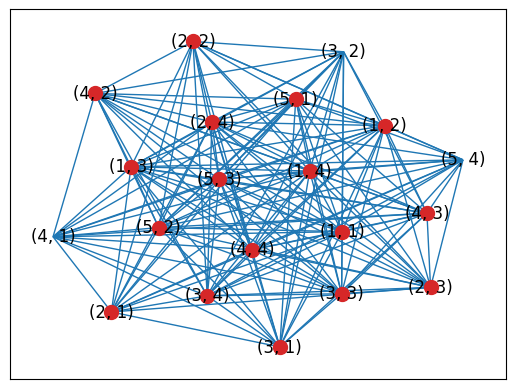

In [3]:
nx.draw_networkx(G, nodelist=mvc, node_size=100, node_color='tab:red',edge_color='tab:blue', with_labels=True) 


8.951069615654882


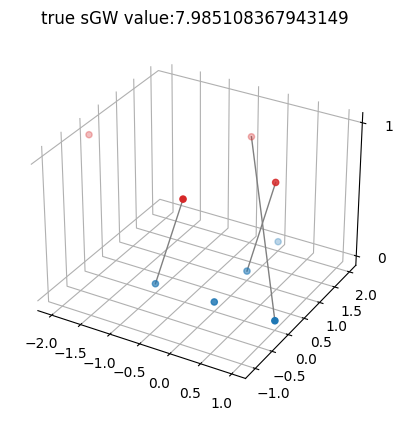

7.985108367943149


In [4]:
threshold = 0.2
gamma = 10
eps = 1e-2
eta = 1
verbose = False
nitermax = 20
random_state=1
np.random.seed(random_state)

def perform_sOT_log(G, a, b, eps, options):

    niter = options['niter_sOT']
    f     = options['f_init']
    g     = options['g_init']
    M     = options['penalty']

    # Err = np.array([[1, 1]])

    for q in range(niter):   
        f = np.minimum(eps * np.log(a) - eps * np.log(np.sum(np.exp((f[:, None] + g[None, :]  - G) / eps), axis=1)+ 10**-20) + f, M)
        g = np.minimum(eps * np.log(b) - eps * np.log(np.sum(np.exp((f[:, None] + g[None, :]  - G) / eps), axis=0)+ 10**-20) + g, M)

    P = np.exp((f[:, None] + g[None, :] - G) / eps)
    
    return P, f, g


a = np.array([1 / n] * n, dtype=float)
aa = a + 1e-1 * np.random.rand(n)
b = np.array([1 / m] * m, dtype=float)
bb = b + 1e-1 * np.random.rand(m)

aa = aa / np.linalg.norm((aa), ord=1)
bb = bb / np.linalg.norm((bb), ord=1)
    
#real convergence value
#eta = eps/(np.sqrt(2)* n * m * min(np.max(a), np.max(b)) * max(np.max(C1)**2,np.max(C2)**2) + eps)
    
    
P = np.outer(aa, bb) 
f = np.zeros(n)
g = np.zeros(m)
p_values = range(nitermax)
sgw_values = []

print(max(np.max(C1)**2,np.max(C2)**2))

for p in p_values:
        
    D = np.zeros((n, m)) 
    P_reshaped = P.reshape(1, 1, n, m) 
    D = np.sum(tensor4 * P_reshaped, axis=(-2, -1))
    sgw = np.sum(D * P)+gamma*(np.sum(a)+np.sum(b)-2*np.sum(P))+eps*np.sum(P * (np.log(P+10**(-20)*np.ones((n,m)))-np.ones((n,m))))
    sgw_values.append(sgw)
    
    D = 2*eta*D+eps*(eta-1)*np.log(P+10**(-20)*np.ones((n,m)))
                    
    for s, t in mvc:
        D[s-1, t-1] = np.inf
        
    options = {
    'niter_sOT': 10**5,
    'f_init': np.zeros(n),
    'g_init': np.zeros(m),
    'penalty': eta*gamma
    }
        
    P,f,g = perform_sOT_log(D, a, b, eps, options)

######################################################################################
#######################################################################################

def plot_mapping(P,X_1,X_2, thresh=None, linewidth=1, save_path=None):

    fig = plt.figure()
    
    ax = plt.axes(projection='3d') 
    ax.scatter3D(X_1[:,0], X_1[:,1], 0, c='tab:blue')
    ax.scatter3D(X_2[:,0], X_2[:,1], 1, c='tab:red')
    ax.set_title('true sGW value:' + str(sgw_values[19]))
    
    for i in range(P.shape[1]):
        if P[:,i].sum() < thresh: continue
        j = np.argmax(P[:,i])
        ax.plot3D([X_1[j,0], X_2[i,0]],[X_1[j,1], X_2[i,1]],[0,1],c='gray', linewidth=linewidth)
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.set_zticks([0, 1])
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()

plot_mapping(P, mesh1, mesh2, thresh=0.00000001, save_path='5vs4_true.png')

np.savetxt('test_appro_0521.csv', P, delimiter=',', fmt='%.10f')
print(sgw_values[19])

In [5]:
#generate all minimal vc test(DON'T MODIFY)

In [6]:
import networkx as nx

def is_vertex_cover(graph, cover):
    """
    Check if a given set of vertices is a vertex cover for the graph.
    Parameters:
    graph (networkx.Graph): The graph.
    cover (list or set): List or set of vertices representing the vertex cover.
    Returns:
    bool: True if the set is a vertex cover, False otherwise.
    """
    for u, v in graph.edges():
        if u not in cover and v not in cover:
            return False
    return True

def generate_minimal_vertex_covers(graph):
    """
    Generate all minimal vertex covers for the graph using backtracking.
    Parameters:
    graph (networkx.Graph): The graph.
    Returns:
    list: List of lists, each representing a minimal vertex cover.
    """
    V = list(graph.nodes())
    covers = []

    def backtrack(cover, vertices):
        if is_vertex_cover(graph, cover):
            # Check if any existing cover is a subset of the current cover
            if not any(set(cover).issuperset(set(c)) for c in covers):
                # Remove any covers that are supersets of the current cover
                covers[:] = [c for c in covers if not set(c).issuperset(set(cover))]
                covers.append(list(cover))
            return

        for i in range(len(vertices)):
            new_cover = cover + [vertices[i]]
            new_vertices = vertices[i+1:]
            backtrack(new_cover, new_vertices)
    
    backtrack([], V)
    return covers

def is_minimal_vertex_cover(graph, vertex_cover):
    """
    Check if the given vertex cover is minimal.
    Parameters:
    graph (networkx.Graph): The graph.
    vertex_cover (set): Set of vertices representing the vertex cover.
    Returns:
    bool: True if the vertex cover is minimal, False otherwise.
    """
    def is_vertex_cover(graph, cover):
        for u, v in graph.edges():
            if u not in cover and v not in cover:
                return False
        return True

    # Check if the given vertex cover is indeed a vertex cover
    if not is_vertex_cover(graph, vertex_cover):
        return False

    # Check if any proper subset is also a vertex cover
    for v in vertex_cover:
        subset = vertex_cover - {v}
        if is_vertex_cover(graph, subset):
            return False

    return True


minimal_vertex_covers = generate_minimal_vertex_covers(G)
print("All "+ str(np.size(minimal_vertex_covers))+ " Minimal Vertex Covers:")

for cover in minimal_vertex_covers:
    print(f"Cover: {cover} with size {len(set(cover))} is minimal: {is_minimal_vertex_cover(G, set(cover))}")


All 22 Minimal Vertex Covers:
Cover: [(1, 1), (1, 2), (1, 3), (1, 4), (2, 1), (2, 2), (2, 3), (2, 4), (3, 1), (3, 2), (3, 3), (3, 4), (4, 1), (4, 2), (4, 3), (4, 4), (5, 1), (5, 2), (5, 4)] with size 19 is minimal: True
Cover: [(1, 1), (1, 2), (1, 3), (1, 4), (2, 1), (2, 2), (2, 3), (2, 4), (3, 1), (3, 2), (3, 3), (3, 4), (4, 1), (4, 2), (4, 3), (5, 1), (5, 3), (5, 4)] with size 18 is minimal: True
Cover: [(1, 1), (1, 2), (1, 3), (1, 4), (2, 1), (2, 2), (2, 3), (2, 4), (3, 1), (3, 2), (3, 3), (3, 4), (4, 1), (4, 2), (4, 3), (5, 2), (5, 3), (5, 4)] with size 18 is minimal: True
Cover: [(1, 1), (1, 2), (1, 3), (1, 4), (2, 1), (2, 2), (2, 3), (2, 4), (3, 1), (3, 2), (3, 3), (4, 1), (4, 2), (4, 3), (4, 4), (5, 1), (5, 3), (5, 4)] with size 18 is minimal: True
Cover: [(1, 1), (1, 2), (1, 3), (1, 4), (2, 1), (2, 2), (2, 3), (2, 4), (3, 1), (3, 2), (3, 3), (4, 1), (4, 2), (4, 3), (4, 4), (5, 2), (5, 3), (5, 4)] with size 18 is minimal: True
Cover: [(1, 1), (1, 2), (1, 3), (1, 4), (2, 1), (2, 

/Users/salovjade/anaconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3202: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size


In [7]:
#sgw

In [8]:
sgw_list = []
P_matrices_list = []


for cover in minimal_vertex_covers:
    a = np.array([1 / n] * n, dtype=float)
    aa = a + 1e-1 * np.random.rand(n)
    b = np.array([1 / m] * m, dtype=float)
    bb = b + 1e-1 * np.random.rand(m)

    aa = aa / np.linalg.norm((aa), ord=1)
    bb = bb / np.linalg.norm((bb), ord=1)

    #real convergence value
    #eta = eps/(np.sqrt(2)* n * m * min(np.max(a), np.max(b)) * max(np.max(C1)**2,np.max(C2)**2) + eps)


    P = np.outer(aa, bb) 
    f = np.zeros(n)
    g = np.zeros(m)
    p_values = range(nitermax)

    print(max(np.max(C1)**2,np.max(C2)**2))

    for p in p_values:

        D = np.zeros((n, m)) 
        P_reshaped = P.reshape(1, 1, n, m) 
        D = np.sum(tensor4 * P_reshaped, axis=(-2, -1))
        sgw = np.sum(D * P)+gamma*(np.sum(a)+np.sum(b)-2*np.sum(P))+eps*np.sum(P * (np.log(P+10**(-20)*np.ones((n,m)))-np.ones((n,m))))

        D = 2*eta*D+eps*(eta-1)*np.log(P+10**(-20)*np.ones((n,m)))

        for s, t in set(cover):
            D[s-1, t-1] = np.inf

        options = {
        'niter_sOT': 10**5,
        'f_init': np.zeros(n),
        'g_init': np.zeros(m),
        'penalty': eta*gamma
        }

        P,f,g = perform_sOT_log(D, a, b, eps, options)
        
    sgw_list.append(sgw)
    P_matrices_list.append(P)

P_matrices_tensor = np.array(P_matrices_list)    
np.save('5vs4_P_allmvc.npy', P_matrices_tensor)
np.save('5vs4_sgw_allmvc.npy', sgw_list)
  

8.951069615654882
8.951069615654882
8.951069615654882
8.951069615654882
8.951069615654882
8.951069615654882
8.951069615654882
8.951069615654882
8.951069615654882
8.951069615654882
8.951069615654882
8.951069615654882
8.951069615654882
8.951069615654882
8.951069615654882
8.951069615654882
8.951069615654882
8.951069615654882
8.951069615654882
8.951069615654882
8.951069615654882
8.951069615654882


In [9]:
min_sgw_mvc_value = np.min(sgw_list)
min_indices = np.where(sgw_list == min_sgw_mvc_value)[0]
min_sgw_mvc_value

7.985108367943149

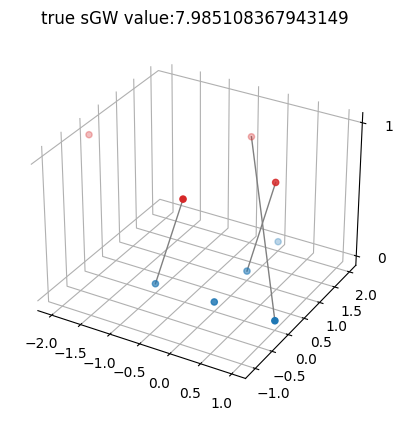

7.985108367943149


In [13]:
def plot_mapping(P,X_1,X_2, thresh=None, linewidth=1, save_path=None):

    fig = plt.figure()
    
    ax = plt.axes(projection='3d') 
    ax.scatter3D(X_1[:,0], X_1[:,1], 0, c='tab:blue')
    ax.scatter3D(X_2[:,0], X_2[:,1], 1, c='tab:red')
    ax.set_title('true sGW value:' + str(min_sgw_mvc_value))
    
    for i in range(P.shape[1]):
        if P[:,i].sum() < thresh: continue
        j = np.argmax(P[:,i])
        ax.plot3D([X_1[j,0], X_2[i,0]],[X_1[j,1], X_2[i,1]],[0,1],c='gray', linewidth=linewidth)
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.set_zticks([0, 1])
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()

plot_mapping(P_matrices_tensor[min_indices[0]], mesh1, mesh2, thresh=0.00000001, save_path='5vs4_allmvc.png')
np.savetxt('5vs4_allmvc.csv', P_matrices_list[min_indices[0]], delimiter=',', fmt='%.10f')
print(min_sgw_mvc_value)

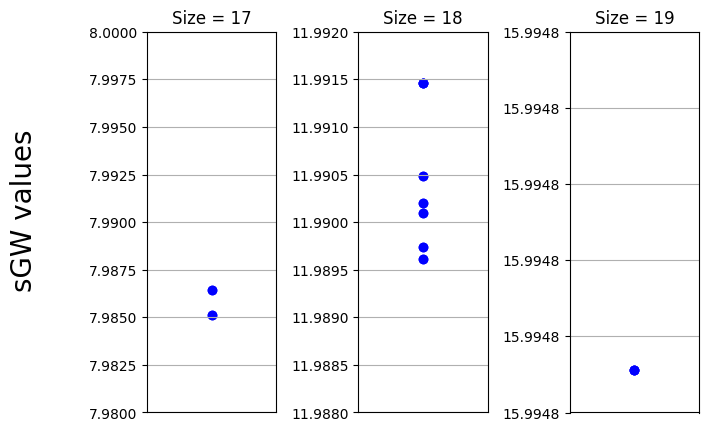

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

#sgw_plot_list = np.load('5vs4_sgw_allmvc.npy')
sgw_plot_list = np.array([15.99478112, 11.98961123, 11.98973987, 11.98961123, 11.98973987,
                          7.98510837,  7.98510837, 15.99478112,  7.98644519,  7.98644519,
                          11.99048312, 11.99146032, 11.99048312, 11.99146032, 11.9902048,
                          11.99146032, 11.9902048, 11.99146032, 15.99478112, 15.99478112,
                          11.99010064, 11.99010064])
mvc_size_list = [19, 18, 18, 18, 18, 17, 17, 19,
                 17, 17, 18, 18, 18, 18, 18, 18,
                 18, 18, 19, 19, 18, 18]

# Separate the data based on x values
x_values = [17, 18, 19]
y_limits = {
    17: (7.98, 8.0),
    18: (11.988, 11.992),
    19: (15.99478, 15.99479)
}

# Formatter function to format y-axis ticks
def format_func(value, tick_number):
    return f'{value:.4f}'

# Create the figure and subplots
fig, axs = plt.subplots(1, 3, figsize=(6.4, 4.8), sharey=False)

for i, x in enumerate(x_values):
    # Select the y values corresponding to the current x value
    y_values = sgw_plot_list[np.array(mvc_size_list) == x]
    
    # Plot the data on the corresponding subplot
    axs[i].scatter([x]*len(y_values), y_values, color='blue')
    #axs[i].scatter(17, 7.98510837, color='red')
    axs[i].set_title(f'Size = {x}')
    axs[i].set_xticks([])
    axs[i].set_ylim(y_limits[x])  # Set the y-axis limits
    axs[i].yaxis.set_major_formatter(FuncFormatter(format_func))

# Set the common y label
fig.text(-0.1, 0.5, 'sGW values', va='center', rotation='vertical', fontsize=20)

# Add a common title
#plt.suptitle('sGW values for All MVCs',fontsize=20)

# Show grid and adjust layout
for ax in axs:
    ax.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Show the plot
plt.savefig('5vs4_sgw.png', dpi=300, bbox_inches='tight')

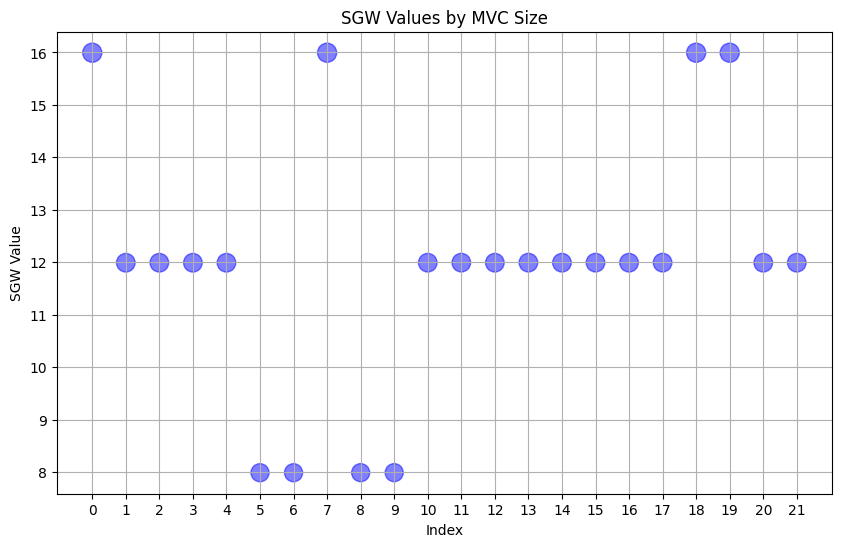

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Data
sgw_plot_list = np.array([15.99478112, 11.98961123, 11.98973987, 11.98961123, 11.98973987,
                          7.98510837,  7.98510837, 15.99478112,  7.98644519,  7.98644519,
                          11.99048312, 11.99146032, 11.99048312, 11.99146032, 11.9902048,
                          11.99146032, 11.9902048, 11.99146032, 15.99478112, 15.99478112,
                          11.99010064, 11.99010064])
mvc_size_list = [19, 18, 18, 18, 18, 17, 17, 19,
                 17, 17, 18, 18, 18, 18, 18, 18,
                 18, 18, 19, 19, 18, 18]

# Normalizing the size for better visualization
sizes = np.array(mvc_size_list) * 10  # Scale factor for visibility, adjust as needed

plt.figure(figsize=(10, 6))
plt.scatter(range(len(sgw_plot_list)), sgw_plot_list, s=sizes, color='b', alpha=0.5)
plt.title('SGW Values by MVC Size')
plt.xlabel('Index')
plt.ylabel('SGW Values')
plt.xticks(range(len(sgw_plot_list)), labels=range(len(sgw_plot_list)))  # Set x-tick labels to match the index

plt.grid(True)
plt.show()


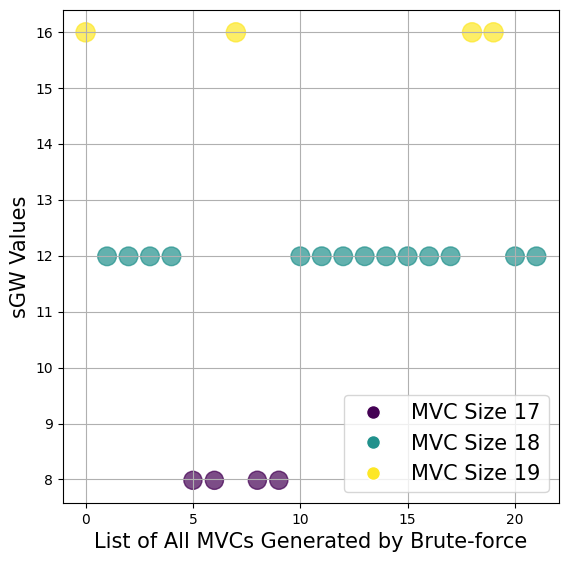

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.cm as cm

# Data
sgw_plot_list = np.array([15.99478112, 11.98961123, 11.98973987, 11.98961123, 11.98973987,
                          7.98510837,  7.98510837, 15.99478112,  7.98644519,  7.98644519,
                          11.99048312, 11.99146032, 11.99048312, 11.99146032, 11.9902048,
                          11.99146032, 11.9902048, 11.99146032, 15.99478112, 15.99478112,
                          11.99010064, 11.99010064])
mvc_size_list = [19, 18, 18, 18, 18, 17, 17, 19,
                 17, 17, 18, 18, 18, 18, 18, 18,
                 18, 18, 19, 19, 18, 18]

# Normalizing the size for better visualization
sizes = np.array(mvc_size_list) * 10  # Scale factor for visibility, adjust as needed

# Create a color map based on MVC sizes
unique_sizes = np.unique(mvc_size_list)
colors = cm.viridis(np.linspace(0, 1, len(unique_sizes)))
color_map = {size: color for size, color in zip(unique_sizes, colors)}

# Map MVC sizes to colors
point_colors = [color_map[size] for size in mvc_size_list]

plt.figure(figsize=(6.4, 6.4))
scatter = plt.scatter(range(len(sgw_plot_list)), sgw_plot_list, s=sizes, c=point_colors, alpha=0.7)
#plt.title('SGW Values by MVC Size')
plt.xlabel('List of All MVCs Generated by Brute-force',fontsize=15)
plt.ylabel('sGW Values',fontsize=15)

# Create a custom legend
handles = [plt.Line2D([0], [0], marker='o', color='w', label=f'MVC Size {size}', 
                      markerfacecolor=color, markersize=10) for size, color in color_map.items()]
plt.legend(handles=handles,fontsize=15)

plt.grid(True)
plt.savefig('5vs4_sgw_all.png', dpi=300, bbox_inches='tight')
plt.show()
